# <center>Visualization & Style Transfer<center/>

<center>Shan-Hung Wu & DataLab<center/>
<center>Fall 2023<center/>

This tutorial is going to show how to load and use a pretrained model from tensorflow library and discusses some techniques to visualize what the networks represent in the selected layers. In addition, we will introduce an interesting work called neural style transfer, using deep learning to compose one image in the style of another image.

## Import and configure modules

In [1]:
import tensorflow as tf
import numpy as np
import time
import functools
import IPython.display as display
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl
import os


''' 
runtime configuration parameters 
設定了兩個參數:
1. figure.figsize : 設定繪圖的預設圖片尺寸為 (12, 12) 英吋
2. axes.grid : 將繪圖中的網格（grid）關閉，即設為 False
'''
mpl.rcParams['figure.figsize'] = (12,12) 
mpl.rcParams['axes.grid'] = False

2023-11-10 16:54:39.958212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


2023-11-10 16:54:41.357023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-10 16:54:41.357153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-10 16:54:41.361011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-10 16:54:41.361112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-10 16:54:41.361202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

# <center>Visualize Convolutional Neural Networks<center/>

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [17]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) # 將圖片的數據類型轉換為 tf.float32。這是為了將像素值縮放到範圍 [0, 1]，以便進行後續的處理。
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)  # 將 shape 的 tensor 轉換為 float32
    long_dim = max(shape) 
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32) # 滿足 max_dim 的 shape

    img = tf.image.resize(img, new_shape)
    # in order to use CNN, add one additional dimension 
    # to the original image
    # img shape: [height, width, channel] -> [batch_size, height, width, channel]
    img = img[tf.newaxis, :] # 增加一個 batch 的維度
    
    return img

Create a simple function to display an image:

In [20]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

tf.Tensor([ 980 1141], shape=(2,), dtype=int32)
tf.Tensor([ 980. 1141.], shape=(2,), dtype=float32)
Image shape: (1, 439, 512, 3)


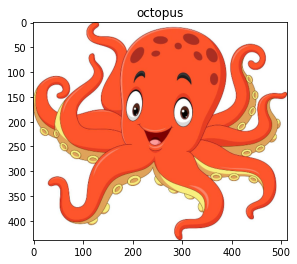

In [21]:
content_path = '/home/s111062697/Deep_learning/lecture11-2/tutorial/octopus.jpg'
content_image = load_img(content_path)
print('Image shape:', content_image.shape)
imshow(content_image, 'octopus')

## Load a pretrained network (VGG19)

We are going to visualize one of most remarkable neural networks, VGG19, which is introduced from this [paper](https://arxiv.org/abs/1409.1556), pretrained on ImageNet. VGG19 is known for its simplicity, using only 3×3 convolutional layers stacked on top of each other in increasing depth. The "19" in its name stands for the number of layers in the network. ImageNet is a large dataset used in ImageNet Large Scale Visual Recognition Challenge(ILSVRC). The training dataset contains around 1.2 million images composed of 1000 different types of objects. The pretrained network learned how to create useful representations of the data to differentiate between different classes.

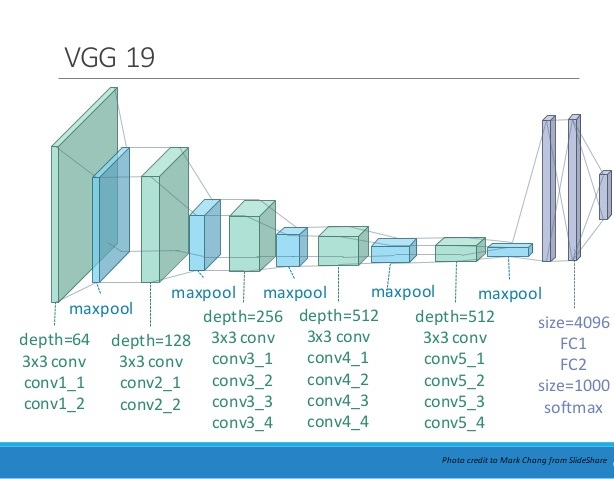

Load a VGG19 and test run it on our image to ensure it's used correctly. The output of VGG19 is the probabilities corresponding to 1000 categories.

In [22]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255) # 以 VGG19 模型的預處理方式來處理一個影像 content_image*255，是因為 VGG19 模型預處理的期望輸入值是在 0 到 255 之間的像素值。
x = tf.image.resize(x, (224, 224)) # VGG19 模型預期的輸入影像大小是 (224, 224, 3)

# load pretrained network(VGG19)
# include_top=True 表示包含模型的頂層（全連接層），而 weights='imagenet' 則表示使用在 ImageNet 數據集上預先訓練好的權重。
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')


prediction_probabilities = vgg(x) # 包含類別預測機率的張量
prediction_probabilities.shape

574710816/574710816 [==============================] - 51s 0us/step


2023-11-10 19:21:23.869256: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-11-10 19:21:33.762260: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


TensorShape([1, 1000])

Obtain the top 5 predicted categories of the input image.

In [23]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 1us/step


[('jigsaw_puzzle', 0.24402003),
 ('hook', 0.15617773),
 ('comic_book', 0.035165265),
 ('coffee_mug', 0.028843615),
 ('envelope', 0.02870954)]

Let's try to first print out the detailed structure of VGG19. vgg.summary() shows the name, output shape and the number of parameters of each layer.

In [24]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Visualize filters